# Healthcare insurance fraud identification using PCA anomaly detection


## 1. Background <a name="background"></a>
Medicare is a federal healthcare program created in 1965 with the passage of the Social Security Amendments to ensure that citizens 65 and older as well as younger persons with certain disabilities have access to quality healthcare. Medicare is administered by the Centers for Medicare and Medicaid Services (CMS). CMS manages Medicare programs by selecting official Medicare administrative contractors (MACs) to process the Medicare claims associated with various parts of Medicare. We propose a solution to apply unsupervised outlier techniques at post-payment stage to detect fraudulent patterns of received insurance claims. 

Health care insurance fraud is a pressing problem, causing substantial and increasing costs in medical insurance programs. Due to large amounts of claims submitted, review of individual claims becomes a difficult task and encourages the employment of automated pre-payment controls and better post-payment decision support tools to enable subject matter expert analysis. We will demonstrate the unsupervised anomalous outlier techniques on a minimal set of metrics made available in the CMS Medicare inpatient claims from 2008. Once more data is available as extracts from different systems  -Medicaid Information Management systems(MMIS), Medicaid Statistical Information Systems(MSIS), Medicaid Reference data such as Provider Files, Death Master Files, etc. - there is an opportunity to build a database of metrics to make the fraud detection technique more robust. The method can be used to flag claims as a targeting method for further investigation. 

## 2. Setup <a name="setup"></a>

To begin, we'll install the Python libraries we'll need for the remainder of the exercise.

In [ ]:
# Install a pip columnize package in the current Jupyter kernel
%pip install --user columnize gensim==3.8.3

In [ ]:
%pip install --user nltk

In [ ]:
%pip install pyod

In [101]:
%pip install yellowbrick

     |████████████████████████████████| 271 kB 5.3 MB/s            
Note: you may need to restart the kernel to use updated packages.


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [37]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from IPython.display import display               # For displaying outputs in the notebook
import matplotlib.pyplot as plt                   #for interactive plots and simple cases of programmatic plot generation
%matplotlib inline                                
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        #provides access to some variables used or maintained by the interpreter
import os                                         # For manipulating filepath names
import time                                       #provides various time-related functions
import warnings                                   #allows you to handle all warnings with the standard logging
import io                                         #interface to access files and streams
warnings.filterwarnings(action = 'ignore')        #warnings filter controls whether warnings are ignored, displayed
from sklearn.model_selection import train_test_split #Quick utility to split data into train and test set
import gensim                                     #topic modelling library for Python that provides access to Word2Vec
import columnize                                  #format a simple (i.e. not nested) list into aligned columns.
from gensim.models import Word2Vec                #topic modelling library for Python that provides access to Word2Vec
from sklearn.manifold import TSNE                 #containing T-SNE algorithms used to project high dimensional space into lower dimesional space
from numpy.linalg import inv                      #Compute the dot product of two or more arrays in a single function call
import scipy.stats                                #contains a large number of probability distributions for statistical analysis
import scipy as sp                                #collection of mathematical algorithms
import seaborn as sns                             #data visualization library based on matplotlib
import pyod

## 3. Data<a name="data"></a>

The dataset we'll be using in this example was downloaded from following link.
https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Inpatient_Claims.html

The data set is the public available Basic Stand Alone (BSA) Inpatient Public Use Files (PUF) named “CMS 2008 BSA Inpatient Claims PUF”. The file contains Medicare inpatient claims from 2008. Each record is an inpatient claim incurred by a 5% sample of Medicare beneficiaries. The file contains seven (7) variables: A primary claim key indexing the records and six (6) analytic variables. One of the analytic variables, claim cost, is provided in two forms, (a) as an integer category and (b) as a dollar average. There are some demographic and claim-related variables provided in this PUF. 

However, as beneficiary identities are not provided, it is not possible to link claims that belong to the same beneficiary in the CMS 2008 BSA Inpatient Claims PUF. Without linking beneficiary Id to the claims, it is not possible to create features such as 'amount reimbursed over time', 'average reimbursement per visit' etc.

### 3A. Obtain data<a name="datasetfiles"></a>

We will use the following link to download claims dataset.

https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip

The data dictionary required to interpret codes in dataset have been constructed from following pdf document.

https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF_DataDic_CB.pdf

Following dictionary files are already avaliable in data folder in the notebook.
- `ColumnNames.csv` - column description
- `DiagnosisRelatedGroupNames.csv` - dictionary for procedure codes
- `InternationalClassificationOfDiseasesNames.csv` - dictionary of diagnosis codes
- `LengthOfStayDays.csv` - dictionary of length of stay
- `AgeGroup.csv` - dictionary of age group
- `Gender.csv` - dictionary of gender

#### Download claims data file from CMS site.

In [ ]:
!wget https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip
!unzip -o ./2008_BSA_Inpatient_Claims_PUF-backup.zip -d data

#### The data file have been extrcated under data folder locally on Sagemaker notebook volume in the data folder.

- `2008_BSA_Inpatient_Claims_PUF.csv` - claims data

#### Let's begin exploring data:

## 4. Feature Engineering <a name="feateng"></a>

In [3]:
# read the ColumnNames csv file to identify meaningful names for column labels in the claim data
colnames = pd.read_csv("./data/ColumnNames.csv")
colnames[colnames.columns[-1]] = colnames[colnames.columns[-1]].map(lambda x: x.replace('"','').strip())
display(colnames)

,Column Label,"""Column Name"""
0,IP_CLM_ID,Encrypted PUF ID
1,BENE_SEX_IDENT_CD,Beneficiary gender code
2,BENE_AGE_CAT_CD,Beneficiary Age category code
3,IP_CLM_BASE_DRG_CD,Base DRG code
4,IP_CLM_ICD9_PRCDR_CD,ICD9 primary procedure code
5,IP_CLM_DAYS_CD,Inpatient days code
6,IP_DRG_QUINT_PMT_AVG,DRG quintile average payment amount
7,IP_DRG_QUINT_PMT_CD,DRG quintile payment amount code


In [4]:
# read claims data file
df_cms_claims_data = pd.read_csv('./data/2008_BSA_Inpatient_Claims_PUF.csv')
df_cms_claims_data.columns = colnames[colnames.columns[-1]].ravel()
pd.set_option('display.max_columns', 500)

# print the shape of the data file
print('Shape:', df_cms_claims_data.shape)

# show the top few rows
display(df_cms_claims_data.head())

# describe the data object
display(df_cms_claims_data.describe())

# check the datatype for each column
display(df_cms_claims_data.dtypes)

# check null value for each column
display(df_cms_claims_data.isnull().mean())

Shape: (588415, 8)


,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
0,IP-000022CE4125DBE7,2,4,3,31.0,4,86240,4
1,IP-0000417F50942D90,2,5,199,NaN,2,3447,2
2,IP-0000865F5457AC0E,1,1,119,54.0,4,34878,5
3,IP-00009789630AF474,2,2,128,NaN,2,3007,2
4,IP-0000C9D229B79D36,2,2,236,70.0,1,3352,2


,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
count,588415.000000,588415.000000,588415.000000,311869.000000,588415.000000,588415.000000,588415.000000
mean,1.561165,3.574610,140.202393,59.683832,2.516377,9312.621422,2.999444
std,0.496245,1.805788,79.686699,29.207527,0.972758,10482.707298,1.414880
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,2.000000,82.000000,38.000000,2.000000,4008.000000,2.000000
50%,2.000000,4.000000,123.000000,54.000000,2.000000,6352.000000,3.000000
75%,2.000000,5.000000,200.000000,86.000000,3.000000,10760.000000,4.000000
max,2.000000,6.000000,311.000000,99.000000,4.000000,329467.000000,5.000000


Encrypted PUF ID                        object
Beneficiary gender code                  int64
Beneficiary Age category code            int64
Base DRG code                            int64
ICD9 primary procedure code            float64
Inpatient days code                      int64
DRG quintile average payment amount      int64
DRG quintile payment amount code         int64
dtype: object

Encrypted PUF ID                       0.000000
Beneficiary gender code                0.000000
Beneficiary Age category code          0.000000
Base DRG code                          0.000000
ICD9 primary procedure code            0.469985
Inpatient days code                    0.000000
DRG quintile average payment amount    0.000000
DRG quintile payment amount code       0.000000
dtype: float64

#### You might have observed some 'NaN' and mean value(0.469985) for ICD9 primary procedure code in print results above.
We need fix to 'NaN' in ICD9 primary procedure code.

### 4A. Missing values<a name="missing"></a>
Do I have missing values? How are they expressed in the data? Should I withhold samples with missing values? Or should I replace them? If so, which values should they be replaced with?

Based on results of isnull.mean(), it is clear that 'ICD9 primary procedure code' has a non zero mean and it is so because it has NaN values. The NaN values corresponds to "No Procedure Performed" in the  in the 'ICD9 primary procedure code' dictionary. Let's replace NaN values with a numeric code for "No Procedure Performed".

In [5]:
#Fill NaN with -1 for "No Procedure Performed"
procedue_na = -1
df_cms_claims_data['ICD9 primary procedure code'].fillna(procedue_na, inplace = True)

#convert procedure code from float to int64
df_cms_claims_data['ICD9 primary procedure code'] = df_cms_claims_data['ICD9 primary procedure code'].astype(np.int64)


#check count of null values to ensure dataframe is updated
display(df_cms_claims_data.isnull().mean())

Encrypted PUF ID                       0.0
Beneficiary gender code                0.0
Beneficiary Age category code          0.0
Base DRG code                          0.0
ICD9 primary procedure code            0.0
Inpatient days code                    0.0
DRG quintile average payment amount    0.0
DRG quintile payment amount code       0.0
dtype: float64

### 4B. Categorical features <a name="catfeat"></a>

Munging categorical data is another essential process during data preprocessing. It is necessary to convert categorical features to a numerical representation.

#### a. Gender <a name="gender"></a>

Since gender is already binary and coded as 1 for Male and 2 for Female, no pre-processing is required.

,bene_sex_ident_cd,Beneficiary gender
0,1,Male
1,2,Female


Text(0, 0.5, 'Percentage claims')

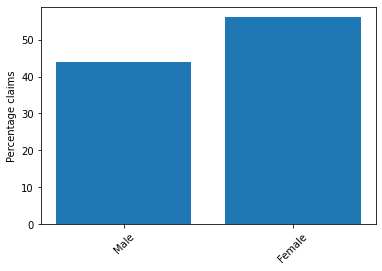

In [6]:
# read gender dictionary csv file
dict_gender = pd.read_csv("./data/Gender.csv")
dict_gender.columns = dict_gender.columns.to_series().apply(lambda x: x.strip())
display(dict_gender)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_gender_counts = dict_gender.set_index('bene_sex_ident_cd').join( df_cms_claims_data['Beneficiary gender code'].value_counts() )
tmp_gender_counts['percentage'] = tmp_gender_counts['Beneficiary gender code']/tmp_gender_counts['Beneficiary gender code'].sum()*100

# project gender distribution in the dataset on the bar graph
plt.bar(tmp_gender_counts.index, tmp_gender_counts['percentage'].tolist());
plt.xticks(tmp_gender_counts.index, tmp_gender_counts['Beneficiary gender'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

#### You may have observed a slight imbalance in claims distribution for male and female records in above bar graph.
Nothing concerning hear. But, we may use this information later in result analysis to justify our anomaly hypothesis.

#### b. Age Group <a name="age"></a>

,BENE_AGE_CAT_CD,Age Group
0,1,Under_65
1,2,65_to_69
2,3,70_to_74
3,4,75_to_79
4,5,80_to_84
5,6,85_and_Older


Text(0, 0.5, 'Percentage claims')

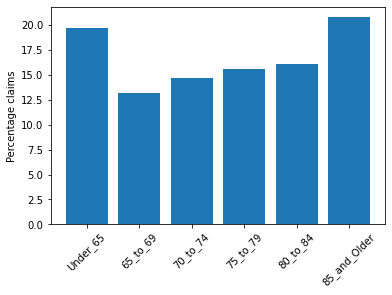

In [7]:
#read AgeGroup csv file into a pandas dataframe
dict_age_group = pd.read_csv("./data/AgeGroup.csv", sep=',')
dict_age_group.columns = dict_age_group.columns.to_series().apply(lambda x: x.strip())
display(dict_age_group)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_age_sorted_counts = dict_age_group.set_index('BENE_AGE_CAT_CD').join( df_cms_claims_data['Beneficiary Age category code'].value_counts() )
tmp_age_sorted_counts['percentage'] = tmp_age_sorted_counts['Beneficiary Age category code']/tmp_age_sorted_counts['Beneficiary Age category code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.bar(tmp_age_sorted_counts.index, tmp_age_sorted_counts['percentage'].tolist());
plt.xticks(tmp_age_sorted_counts.index, tmp_age_sorted_counts['Age Group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

#### You might have observed a slight imbalance in age group group distribution. 
Nothing concerning in above distribution. Small imbalance is OK.

### 4B. NLP for Textual features <a name="nlp"></a>

All physician and hospital claims include one or more diagnosis codes. The ICD-9-CM diagnosis coding system is used since October, 2012.

Hospital inpatient claims also include one or more procedure codes that represent the services performed. The ICD-9-CM diagnosis coding system is used since October, 2012.

The codes are numeric number representing the phrases describing the diagnosis and the procedures itself. The code iteself is numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

For diagnosis and procedure codes there is a option to consider it as categorical code and apply one hot encoding to it. That categorical data is defined as variables with a finite set of label values. We apply a technique called one hot encoding to do binarization of such values. In one hot encode we create one column for each label value and mark it as 0 or 1 as applicable to sample record. In case of dignosis code and procedure code it will give us a sparse matrix. Again, the code iteself will be numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Inorder to capture, capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc. we use a technique called word embedding to convert every word in a phrase into a vector of floating point numbers. We then average the vector for each word in a phrase to derive vector for a phrase. We will use this approach for both diagnosis and procedure descriptions to extract features.

Word2Vec is a specific method to derieve word embeddings. It can be done using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW)

CBOW Model: This method takes the context of each word as the input and tries to predict the word corresponding to the context.

Skip-Gram model: This method uses the target word (whose representation we want to generate) to predict the context and in the process, we produce the representations.

Both model have their own advantages and disadvantages. Skip Gram works well with small amount of data and is found to represent rare words well.

On the other hand, CBOW is faster and has better representations for more frequent words.

In our use case, we will use CBOW model to derieve wordtovec for pharases used to describe procedure and diagnosis code description.

#### a. Diagnosis Descriptions <a name="diagnosis"></a>

,Base DRG code,Diagnosis related group
0,1,Heart transplant or implant of heart assist sy...
1,2,"ECMO or trach w MV 96+ hrs or PDX exc face, mo..."
2,3,"Trach w MV 96+ hrs or PDX exc face, mouth & ne..."
3,4,Liver transplant
4,5,Lung transplant


Base DRG code               int64
Diagnosis related group    object
dtype: object

Text(0, 0.5, 'Percentage claims')

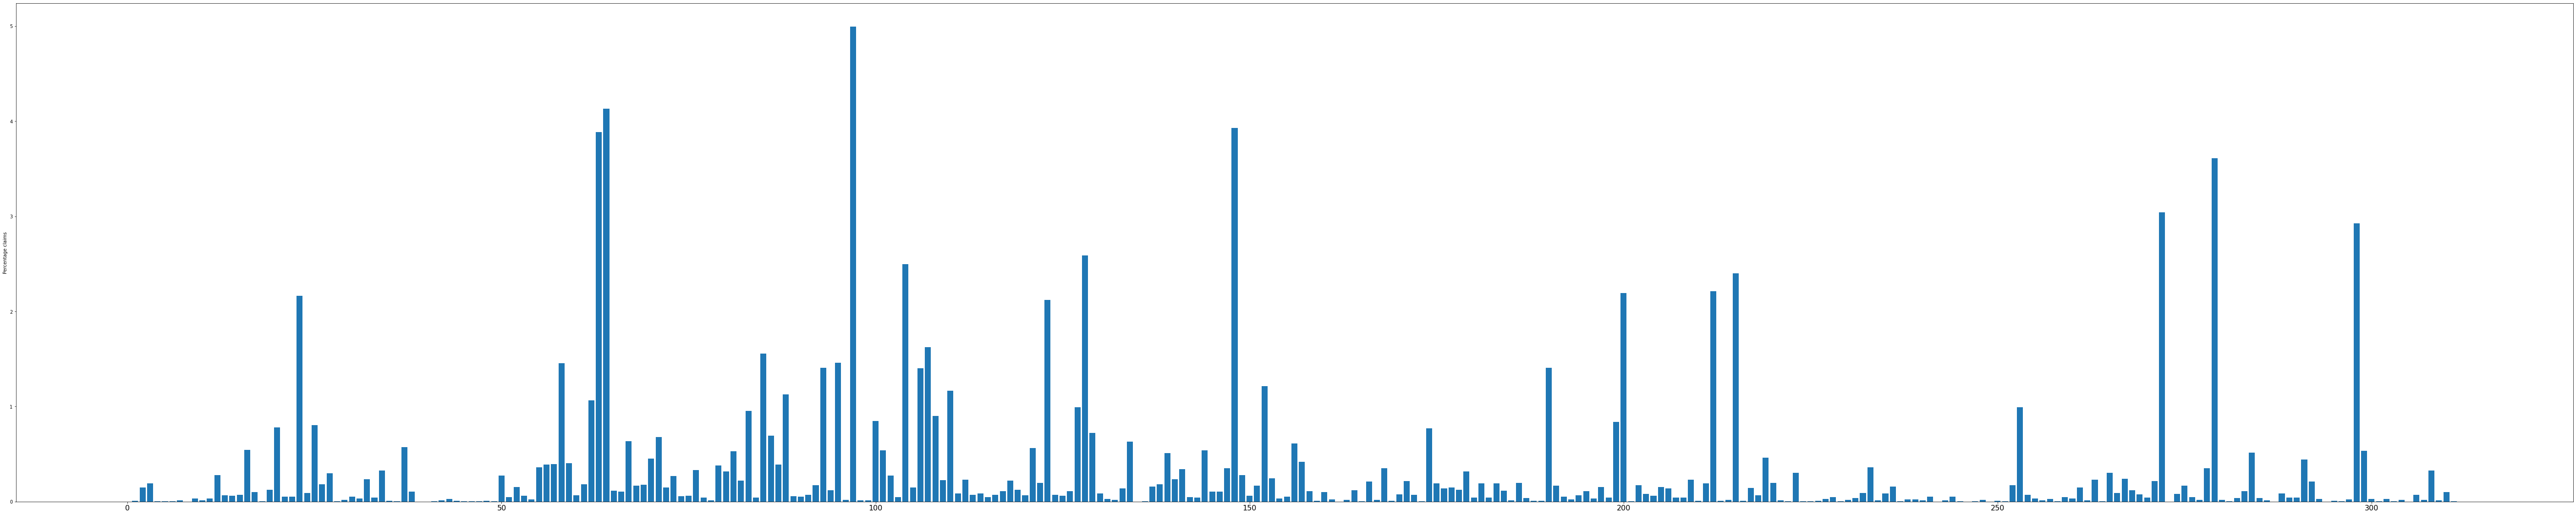

In [8]:
# read the diagnosis names into dataframe, clean up values and display records
dict_diagnosis_names = pd.read_csv('./data/DiagnosisRelatedGroupNames.csv', sep=', "', skiprows=1, names=['Base DRG code','Diagnosis related group']);
dict_diagnosis_names['Diagnosis related group'] = dict_diagnosis_names['Diagnosis related group'].map(lambda x: x.replace('"',''));
display(dict_diagnosis_names.head())
display(dict_diagnosis_names.dtypes)


# join the Base DRG code in dictionay with Base DRG code in claims dataframe and describe the distribution amongst different age group in claims dataset
tmp_diagnosis_counts = dict_diagnosis_names.set_index('Base DRG code').join( df_cms_claims_data['Base DRG code'].value_counts() )
tmp_diagnosis_counts['percentage'] = tmp_diagnosis_counts['Base DRG code']/tmp_diagnosis_counts['Base DRG code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.figure(figsize=(100,20))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_diagnosis_counts.index, tmp_diagnosis_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

#### Observe the distribution of different diagnosis code in above bar graph printed from claims dataset.
Next, let's do text processing on diagnosis descriptions to make some of the acronyms more meaningful for word embeddings

In [9]:
# function to run pre processing on diagnosis descriptions
from nltk.tokenize import sent_tokenize, word_tokenize 

def text_preprocessing(phrase):
    phrase = phrase.lower()
    phrase = phrase.replace('&', 'and')
    #phrase = phrase.replace('non-', 'non') #This is to ensure non-critical, doesn't get handled as {'non', 'critical'}
    phrase = phrase.replace(',','')
    phrase = phrase.replace('w/o','without').replace(' w ',' with ').replace('/',' ')
    phrase = phrase.replace(' maj ',' major ')
    phrase = phrase.replace(' proc ', ' procedure ')
    phrase = phrase.replace('o.r.', 'operating room')
    sentence = phrase.split(' ')
    return sentence

In [10]:
# run pre processing on diagnosis related group
tmp_diagnosis_tokenized = dict_diagnosis_names['Diagnosis related group'].map(lambda x: text_preprocessing(x))
display(tmp_diagnosis_tokenized.head())

0    [heart, transplant, or, implant, of, heart, as...
1    [ecmo, or, trach, with, mv, 96+, hrs, or, pdx,...
2    [trach, with, mv, 96+, hrs, or, pdx, exc, face...
3                                  [liver, transplant]
4                                   [lung, transplant]
Name: Diagnosis related group, dtype: object

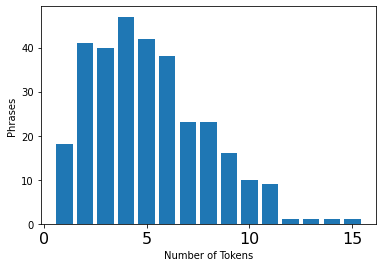

In [11]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
diagnosis_phrase_lengths = tmp_diagnosis_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(diagnosis_phrase_lengths)), diagnosis_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

#### Word to vec hyperparameters explained

**size:** The size of the dense vector that is to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100–150 has worked well for me for similarity lookups.

**window:** The maximum distance between the target word and its neighboring word. If your neighbor’s position is greater than the maximum window width to the left or the right, then some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its not overly narrow or overly broad. If you are not too sure about this, just use the default value.

**min_count:** Minimium frequency count of words. The model would ignore words that do not satisfy the min_count.Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

**workers:** How many threads to use behind the scenes?

**iter:** How many epochs to train for? I typically use 10 or more for a small to medium dataset.

In [12]:
# traing wordtovec model on diagnosis description tokens
model_drg = Word2Vec(tmp_diagnosis_tokenized, min_count = 1, size = 72, window = 5, seed=42, iter=30)
print(model_drg)
diagnosis_words = list(model_drg.wv.vocab)
print(columnize.columnize(diagnosis_words, displaywidth=80, ljust=False))

Word2Vec(vocab=520, size=72, alpha=0.025)
          heart         pulmonary            combined         evisceration
     transplant          embolism            anterior                  rad
             or       respiratory           posterior         hysterectomy
        implant     inflammations              fusion           vulvectomy
             of           pleural                 fus              uterine
         assist          effusion                cerv               adnexa
         system             edema                curv              ovarian
           ecmo           failure               malig              adnexal
          trach           chronic               infec        uterineadnexa
           with       obstructive                  9+          non-ovarian
             mv           disease            cervical       non-malignancy
            96+            simple           bilateral                dandc
            hrs         pneumonia               joint     

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

In [13]:
# plot TSNE visualization
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

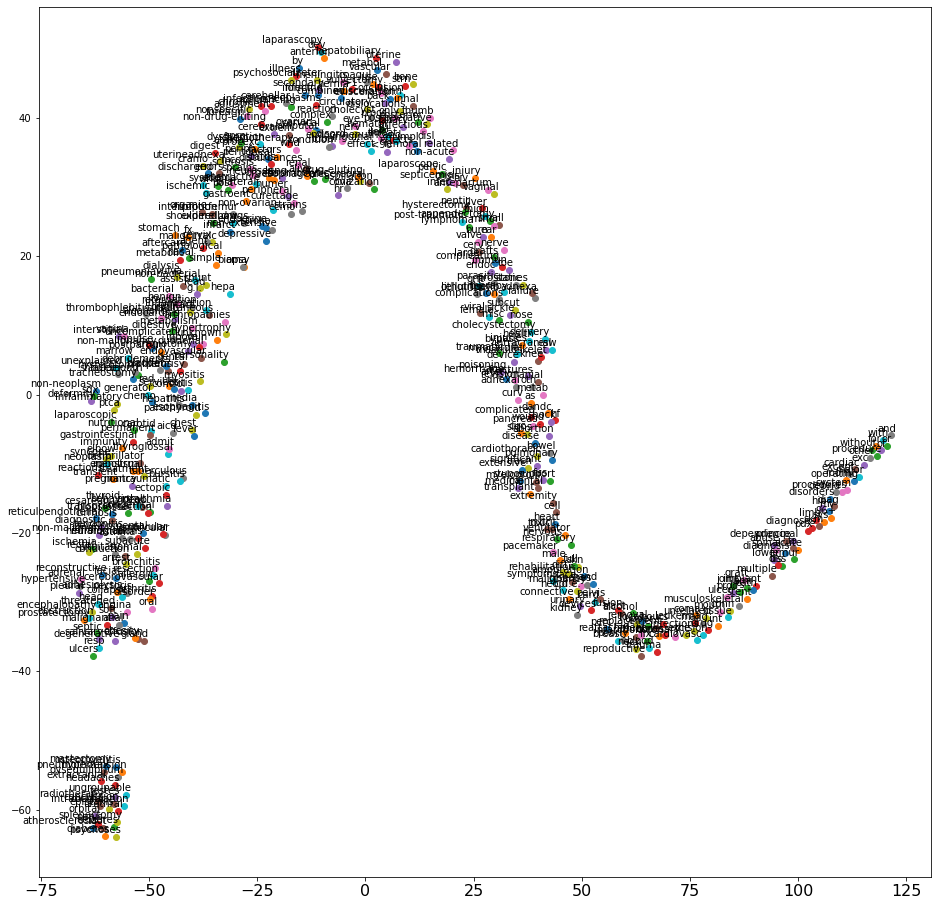

In [14]:
# plot t_SNE chart for diagnosis word to vector. 
#2D visual plot of word embeddings derieved from diagnosis description.
tsne_plot(model_drg)

In [15]:
# test most similiar for some word from model_drg.wv.keywords
model_drg.most_similar('diagnosis')

[('procedure', 0.9972505569458008),
 ('for', 0.9971470236778259),
 ('without', 0.99705970287323),
 ('and', 0.9968159794807434),
 ('other', 0.9967644214630127),
 ('or', 0.9967493414878845),
 ('diag', 0.9965689778327942),
 ('with', 0.9965683221817017),
 ('of', 0.9965642690658569),
 ('except', 0.9965377449989319)]

In [16]:
# extract diagnosis words that starts with non
#display(tmp_diagnosis_tokenized.head())
series_diagnosis = pd.Series(diagnosis_words)
diagnosis_words_with_non = series_diagnosis[series_diagnosis.map(lambda x: 'non' in x)]
display(diagnosis_words_with_non)

76          nonspecific
89         nontraumatic
99        non-bacterial
183    non-drug-eluting
344       non-malignant
370        non-neoplasm
399         non-ovarian
400      non-malignancy
444           non-acute
507       non-extensive
dtype: object

In [17]:
# Check similarity between diagnosis words with opposite severity
for i in diagnosis_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in diagnosis_words:
        print('Cosine similarity between', a, not_a, ':', model_drg.wv.similarity(a, not_a))
        print('')

Cosine similarity between traumatic nontraumatic : 0.83147013

Cosine similarity between bacterial non-bacterial : 0.8029942

Cosine similarity between drug-eluting non-drug-eluting : 0.91427183

Cosine similarity between malignant non-malignant : 0.43197012

Cosine similarity between neoplasm non-neoplasm : 0.6931552

Cosine similarity between ovarian non-ovarian : 0.9089171

Cosine similarity between malignancy non-malignancy : 0.8904966

Cosine similarity between acute non-acute : 0.97487825

Cosine similarity between extensive non-extensive : 0.9458701



In [18]:
# calculate mean of word vector in a phrase to derieve phrase vector for diagnosis description
# we plan to use mean of word vectors to derive word embeddings for a phrase
values = []
index =[]
#iterate through list of strings in each diagnosis phrase
for i, v in pd.Series(tmp_diagnosis_tokenized).items():
    #calculate mean of all word embeddings in each diagnosis phrase
    values.append(model_drg[v].mean(axis =0))
    index.append(i)
tmp_diagnosis_phrase_vector = pd.DataFrame({'Base DRG code':index, 'DRG_VECTOR':values})
display(tmp_diagnosis_phrase_vector.head())

,Base DRG code,DRG_VECTOR
0,0,"[0.093565695, 0.16264331, 0.013566975, -0.0806..."
1,1,"[0.12983042, 0.22181758, 0.01878535, -0.107034..."
2,2,"[0.12825601, 0.22017498, 0.01807042, -0.106105..."
3,3,"[0.04183864, 0.07109678, 0.0077561606, -0.0342..."
4,4,"[0.034858502, 0.05870279, 0.0075166607, -0.023..."


In [19]:
# expand tmp_diagnosis_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
diagnosis_features = tmp_diagnosis_phrase_vector['DRG_VECTOR'].apply(pd.Series)

# rename each variable in diagnosis_features use DRG_F as prefix
diagnosis_features = diagnosis_features.rename(columns = lambda x : 'DRG_F' + str(x + 1))

# view the diagnosis_features dataframe
display(diagnosis_features.head())

,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,0.093566,0.162643,0.013567,-0.080617,-0.004005,0.013013,-0.059214,0.055267,0.099793,0.000437,0.060274,-0.072238,-0.038798,0.002885,0.012328,-0.042323,-0.067643,0.125747,-0.013398,-0.084662,0.061934,-0.063726,-0.107935,-0.006652,-0.011474,0.049646,-0.012159,0.093000,0.045746,-0.017103,-0.021913,0.015630,0.028965,-0.019034,-0.021656,-0.058076,-0.022330,-0.008120,0.042046,-0.018820,0.012005,0.036850,0.142932,-0.077858,0.061968,-0.021540,0.040617,-0.011426,0.035123,-0.080979,0.101480,0.032334,0.105171,0.059018,-0.012096,-0.064452,0.026800,0.028181,0.044322,-0.058907,0.023403,-0.134896,0.041415,0.022216,-0.023536,0.042264,-0.031585,0.022141,-0.006977,-0.113771,0.042360,-0.058268
1,0.129830,0.221818,0.018785,-0.107034,-0.009036,0.022021,-0.077813,0.073527,0.134814,0.001962,0.075624,-0.099208,-0.050655,0.005260,0.018142,-0.063091,-0.090315,0.173020,-0.016623,-0.114774,0.083877,-0.088103,-0.144936,-0.010098,-0.016291,0.067334,-0.017149,0.130209,0.060314,-0.022295,-0.033427,0.022980,0.043761,-0.027992,-0.028695,-0.079196,-0.033565,-0.007592,0.058277,-0.028467,0.016772,0.053197,0.195054,-0.110219,0.082310,-0.032016,0.056518,-0.020624,0.044733,-0.110313,0.136910,0.039333,0.142345,0.079050,-0.013024,-0.084839,0.041715,0.037944,0.059954,-0.085904,0.031362,-0.191282,0.054605,0.026899,-0.031550,0.056341,-0.041341,0.027218,-0.007208,-0.152059,0.055626,-0.078365
2,0.128256,0.220175,0.018070,-0.106105,-0.009809,0.021787,-0.077478,0.072859,0.133903,0.001053,0.074636,-0.098981,-0.050315,0.004936,0.018170,-0.062216,-0.088817,0.171393,-0.016682,-0.113983,0.083442,-0.088090,-0.143348,-0.010185,-0.015845,0.067245,-0.017100,0.129484,0.059818,-0.021655,-0.033443,0.022448,0.043478,-0.027574,-0.029116,-0.079113,-0.034275,-0.008502,0.057846,-0.027980,0.016147,0.053023,0.193164,-0.110534,0.081779,-0.031824,0.055392,-0.020154,0.043909,-0.109285,0.136014,0.038841,0.140919,0.078599,-0.012491,-0.084009,0.041177,0.037120,0.059769,-0.085107,0.030457,-0.190329,0.054356,0.027207,-0.031309,0.055579,-0.041218,0.026621,-0.006868,-0.150647,0.054240,-0.078078
3,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.004840,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.035280,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.008760,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.030510,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758
4,0.034859,0.058703,0.007517,-0.023911,-0.003183,0.004239,-0.027064,0.013043,0.035263,-0.002158,0.019161,-0.022025,-0.013384,0.000899,-0.000157,-0.011646,-0.021436,0.040545,-0.004433,-0.027254,0.018708,-0.024500,-0.042447,-0.003124,-0.003542,0.021322,-0.008489,0.033819,0.019310,-0.007143,-0.007913,0.003249,0.006984,-0.003956,-0.011370,-0.020151,-0.011720,-0.004717,0.019429,-0.005918,0.006540,0.008330,0.051243,-0.032474,0.027277,-0.007643,0.015197,-0.004507,0.016054,-0.027463,0.031525,0.013272,0.037342,0.024683,-0.007226,-0.021902,0.009642,0.011523,0.017075,-0.021749,0.004635,-0.044371,0.013609,0.009239,-0.011828,0.012560,-0.011694,0.013220,-0.008739,-0.042623,0.016969,-0.020572


#### b. Procedure Descriptions <a name="procedure"></a>

Apply the same process that we used for diagnosis description to procedure description to build a feature vector for procedure

In [20]:
#read procedure code and procedure description mappings
dict_procedure_names = pd.read_csv('./data/InternationalClassificationOfDiseasesNames.csv', 
                              sep=', "', 
                              skiprows=1, 
                              names=['ICD9 primary procedure code','International Classification of Diseases'])

#replace double quotes with blank
dict_procedure_names = dict_procedure_names.applymap(lambda x: x.replace('"',''))

# replace -1 as code for 'No procedure performed'. In the dictionary the code is set as blank.
dict_procedure_names.iloc[0]['ICD9 primary procedure code'] = procedue_na

# convert procedure code from float to int64
dict_procedure_names['ICD9 primary procedure code'] = dict_procedure_names['ICD9 primary procedure code'].astype(np.int64)


# check the datatype for each column
display(dict_procedure_names.dtypes)

# display first five records in dictionary
display(dict_procedure_names.head())


ICD9 primary procedure code                  int64
International Classification of Diseases    object
dtype: object

,ICD9 primary procedure code,International Classification of Diseases
0,-1,No procedure performed
1,0,Not elsewhere classified
2,1,Incise-excis brain/skull
3,2,Other skull/brain ops
4,3,Spinal cord & canal ops


In [21]:
display(dict_procedure_names.count())

ICD9 primary procedure code                 101
International Classification of Diseases    101
dtype: int64

Text(0, 0.5, 'Percentage claims')

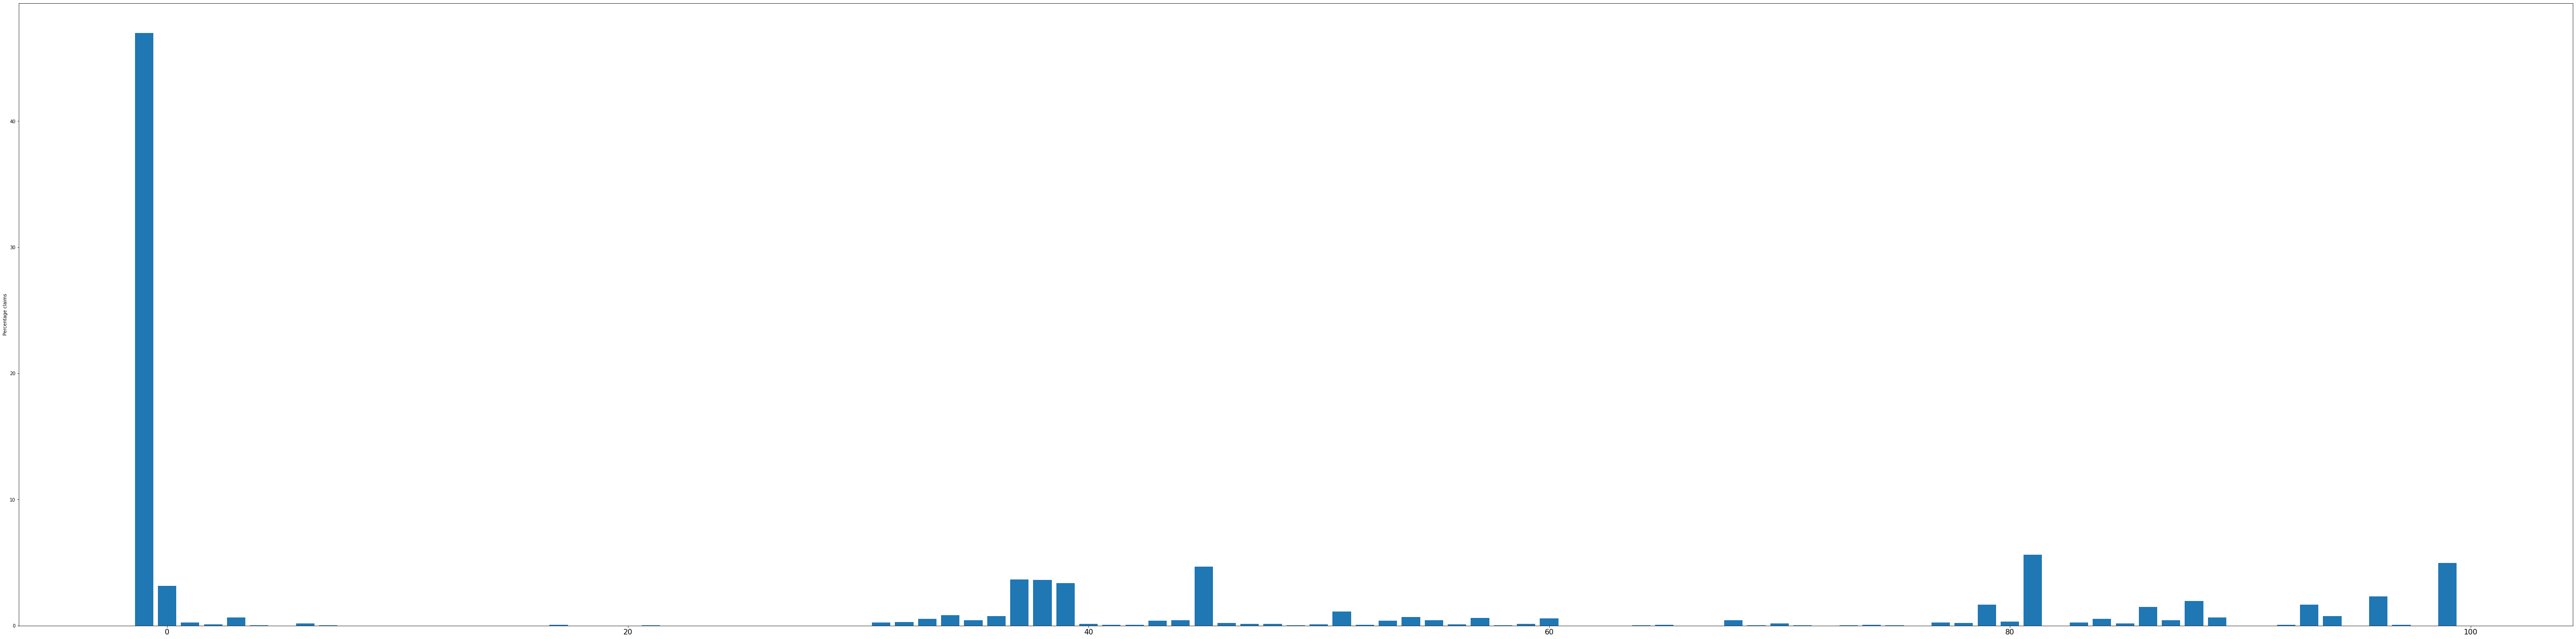

In [22]:
# join the ICD9 primary procedure code in dictionay with ICD9 primary procedure code in claims dataframe and plot the distribution of procedures in the claims dataset
tmp_procedure_counts = dict_procedure_names.set_index('ICD9 primary procedure code').join(df_cms_claims_data['ICD9 primary procedure code'].value_counts() )
tmp_procedure_counts['percentage'] = tmp_procedure_counts['ICD9 primary procedure code']/tmp_procedure_counts['ICD9 primary procedure code'].sum()*100

# project procedure distribution in the claims dataset on the bar graph
plt.figure(figsize=(100,25))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_procedure_counts.index, tmp_procedure_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

In [23]:
# run pre processing on procedure descriptions
tmp_procedure_tokenized = dict_procedure_names['International Classification of Diseases'].map(lambda x: text_preprocessing(x))
display(tmp_procedure_tokenized.head())

0         [no, procedure, performed]
1       [not, elsewhere, classified]
2       [incise-excis, brain, skull]
3         [other, skull, brain, ops]
4    [spinal, cord, and, canal, ops]
Name: International Classification of Diseases, dtype: object

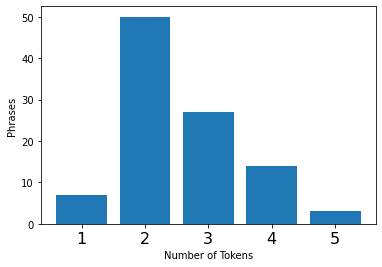

In [24]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
procedure_phrase_lengths = tmp_procedure_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(procedure_phrase_lengths)), procedure_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

In [25]:
# traing wordtovec model on procedure description tokens
model_prc = Word2Vec(tmp_procedure_tokenized, min_count = 1, size = 72, window = 5, iter = 100)
print(model_prc)
procedure_words = list(model_prc.wv.vocab)
print(columnize.columnize(procedure_words, displaywidth=80, ljust=False))

Word2Vec(vocab=193, size=72, alpha=0.025)
          no        segment          of      liver     cul-de-sac    diagnostic
   procedure           lens      larynx    biliary         vulvar     radiology
   performed      posterior     trachea      tract       perineal            dx
         not    extraocular         nec   pancreas         forcep     interview
   elsewhere         muscle        lung     repair            vac       consult
  classified          orbit    bronchus     hernia         breech          exam
incise-excis        eyeball   bronchial    abdomen          deliv   microscopic
       brain  miscellaneous      thorax     region         assist       exam--i
       skull     procedures      except     kidney         induce      exam--ii
       other       external       heart     ureter      c-section       nuclear
         ops            ear      valves    urinary          fetus      medicine
      spinal         middle       septa    bladder      obstetric            p

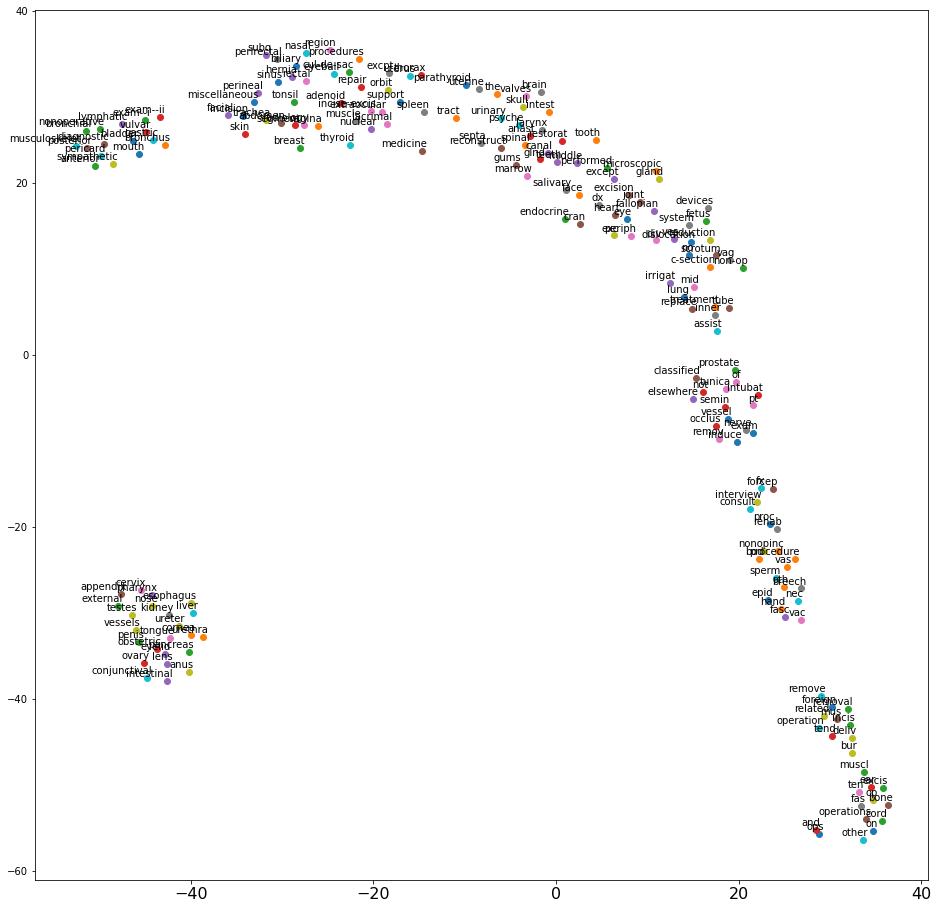

In [26]:
# plot t_SNE chart for procedure word to vector
# #2D visual plot of word embeddings derieved from procedure description.
tsne_plot(model_prc)

In [27]:
# test most similiar for some word from model_prc.wv.keywords
model_prc.most_similar('nonoperative')

[('breech', 0.9422402381896973),
 ('prostate', 0.9414798021316528),
 ('fas', 0.9405962824821472),
 ('vas', 0.9405503869056702),
 ('incis', 0.939283013343811),
 ('of', 0.9390392303466797),
 ('related', 0.9385120272636414),
 ('exc', 0.9380841255187988),
 ('pt', 0.9380760788917542),
 ('ops', 0.937987208366394)]

In [28]:
# extract procedure words that starts with non
#display(tmp_procedure_tokenized.head())
series_procedure = pd.Series(procedure_words)
procedure_words_with_non = series_procedure[series_procedure.map(lambda x: 'non' in x)]
display(procedure_words_with_non)

182          non-op
188           nonop
192    nonoperative
dtype: object

In [29]:
# Check similarity between procedure words with opposite severity
for i in procedure_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in procedure_words:
        print('Cosine similarity between', a, not_a, ':', model_prc.wv.similarity(a, not_a))
        print('')

Cosine similarity between op non-op : 0.98751366

Cosine similarity between op nonop : 0.99284226



In [30]:
# calculate mean of word vector in a phrase to derive phrase vector for procedure description 
values = []
index =[]
#iterate through list of strings in each procedure phrase
for i, v in pd.Series(tmp_procedure_tokenized).items():
    #calculate mean of all word embeddings in each procedure phrase
    values.append(model_prc[v].mean(axis =0))
    index.append(i)
tmp_procedure_phrase_vector = pd.DataFrame({'ICD9 primary procedure code':index, 'PRC_VECTOR':values})
display(tmp_procedure_phrase_vector.head())

,ICD9 primary procedure code,PRC_VECTOR
0,0,"[-0.02277805, 0.033627655, 0.026908582, -0.047..."
1,1,"[-0.019424759, 0.025002634, 0.033845168, -0.05..."
2,2,"[-0.016890274, 0.018713964, 0.024218693, -0.03..."
3,3,"[-0.03990011, 0.06031625, 0.062467497, -0.0930..."
4,4,"[-0.048825525, 0.072397344, 0.06952317, -0.117..."


In [31]:
# expand tmp_procedure_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
procedure_features = tmp_procedure_phrase_vector['PRC_VECTOR'].apply(pd.Series)

# rename each variable in procedure_features use PRC_F as prefix
procedure_features = procedure_features.rename(columns = lambda x : 'PRC_F' + str(x + 1))

# view the procedure_features dataframe
display(procedure_features.head())

,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,-0.022778,0.033628,0.026909,-0.047721,0.031046,0.036986,-0.000116,-0.077879,-0.016604,-0.022349,-0.040022,0.030700,0.032451,0.040377,-0.009145,0.084128,-0.023007,0.022812,-0.002671,0.010981,0.089450,-0.014912,0.034930,0.023013,-0.039885,-0.005053,0.004618,0.014671,0.071473,0.009799,-0.032568,0.007144,-0.052537,-0.018031,-0.012397,0.072893,0.025648,0.019748,-0.040257,0.013410,0.014896,0.002553,0.006913,-0.012085,-0.078013,-0.017671,0.042093,-0.006986,-0.044573,-0.054477,0.018532,-0.027143,0.002255,0.051522,0.017863,-0.021017,0.069111,0.068437,0.026185,0.007189,-0.002595,0.000533,-0.025214,0.065483,0.038913,0.026183,0.002745,0.015194,0.009487,-0.040814,0.005659,0.017700
1,-0.019425,0.025003,0.033845,-0.056764,0.037211,0.036246,0.001087,-0.089489,-0.018807,-0.019091,-0.042726,0.038855,0.023718,0.039812,-0.007878,0.080361,-0.016112,0.022161,-0.001500,0.009807,0.090830,-0.009582,0.038625,0.022342,-0.034668,0.001190,0.003681,0.018014,0.076495,0.014445,-0.034514,0.007512,-0.064600,-0.010157,-0.017790,0.076923,0.027038,0.020290,-0.039769,0.004217,0.018627,0.002874,0.009596,-0.017505,-0.074161,-0.020389,0.043925,-0.004950,-0.038828,-0.055406,0.024489,-0.032299,0.001685,0.051354,0.016647,-0.024039,0.075570,0.071249,0.035709,0.008746,-0.001902,-0.006566,-0.025067,0.075816,0.035914,0.024966,0.001195,0.016954,0.004819,-0.046454,-0.000255,0.016756
2,-0.016890,0.018714,0.024219,-0.032956,0.023996,0.022518,0.001622,-0.057563,-0.012315,-0.020097,-0.025257,0.023455,0.016671,0.028145,-0.004564,0.054927,-0.014245,0.009967,-0.001592,0.009083,0.061327,-0.004707,0.023012,0.020680,-0.028280,-0.002050,0.003944,0.007004,0.049144,0.003260,-0.026992,0.006649,-0.039409,-0.006539,-0.010626,0.048535,0.019971,0.015777,-0.026081,0.010272,0.010719,-0.001913,0.001708,-0.011962,-0.050006,-0.008558,0.032324,-0.004516,-0.029616,-0.036923,0.018652,-0.018570,0.003583,0.041972,0.011346,-0.017964,0.047193,0.048261,0.024005,0.003251,0.000694,-0.006685,-0.012001,0.054077,0.024623,0.018148,-0.001374,0.008258,0.007160,-0.031882,-0.002809,0.011511
3,-0.039900,0.060316,0.062467,-0.093050,0.063531,0.063401,0.001604,-0.150888,-0.033441,-0.043918,-0.067844,0.063945,0.053089,0.073561,-0.014421,0.146294,-0.032225,0.036677,-0.008367,0.023170,0.166005,-0.014295,0.061526,0.051193,-0.069364,-0.012012,0.011490,0.019700,0.130629,0.018052,-0.062311,0.015935,-0.101435,-0.026970,-0.029964,0.129311,0.046848,0.042997,-0.072609,0.017845,0.030058,-0.004375,0.005872,-0.027529,-0.134374,-0.037528,0.078264,-0.012171,-0.080050,-0.097428,0.048772,-0.053014,0.003108,0.097415,0.024492,-0.043534,0.131538,0.126765,0.058923,0.012786,-0.000229,-0.010281,-0.037703,0.134460,0.067315,0.049120,0.004801,0.021223,0.016739,-0.073557,-0.004866,0.029826
4,-0.048826,0.072397,0.069523,-0.117776,0.076166,0.081200,-0.000724,-0.183251,-0.038174,-0.055266,-0.086205,0.073700,0.067125,0.087367,-0.019618,0.181066,-0.034399,0.044697,-0.006827,0.027602,0.205317,-0.019905,0.076919,0.060706,-0.084464,-0.012811,0.013803,0.026838,0.161935,0.028854,-0.074375,0.021966,-0.125426,-0.028998,-0.037750,0.159522,0.058073,0.050416,-0.088232,0.019831,0.035661,-0.005305,0.006899,-0.034558,-0.166994,-0.047083,0.093777,-0.018594,-0.098500,-0.117874,0.056022,-0.062000,0.004793,0.116490,0.026973,-0.052882,0.162146,0.153622,0.070058,0.020128,0.003966,-0.008724,-0.046560,0.159929,0.080471,0.059912,0.012646,0.031487,0.021707,-0.089760,-0.004942,0.037262


In [32]:
#merge diagnosis word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_diagnosis = pd.merge(df_cms_claims_data, diagnosis_features, how='inner', left_on = 'Base DRG code', right_index = True)
display(tmp_join_claim_diagnosis.head())

#merge procedure word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_procedure = pd.merge(tmp_join_claim_diagnosis, procedure_features, how='inner', left_on = 'ICD9 primary procedure code', right_index = True)
display(tmp_join_claim_procedure.head())

#assign new feature set with procedure and diagnosis work embeddings to a new claims feature dataframe
#aggregate all the features extrcated so far to build a final claims feature set for training
claims_features = tmp_join_claim_procedure


,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758
1055,IP-00769E0F26D617F0,1,3,3,31,4,27725,1,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758
1385,IP-009C3541718DECF9,2,4,3,31,4,69162,3,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758
1474,IP-00A71BB8A6B8548E,1,5,3,31,4,86240,4,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.0015

,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758,-0.018597,0.027234,0.030603,-0.0467,0.027409,0.027289,0.000053,-0.073383,-0.016453,-0.021311,-0.029982,0.03032,0.029552,0.038541,-0.008542,0.069495,-0.01788,0.019208,-0.003716,0.005227,0.077673,-0.012438,0.032049,0.020936,-0.030719,-0.004345,0.002212,0.010786,0.061838,0.006974,-0.026825,0.012001,-0.052301,-0.011783,-0.011061,0.059953,0.024498,0.020256,-0.037515,0.010144,0.012299,-0.000208,0.000007,-0.014681,-0.066234,-0.022271,0.036506,-0.009181,-0.039198,-0.044616,0.026535,-0.022518,-0.002592,0.046427,0.012241,-0.022462,0.063208,0.062113,0.026013,0.010111,0.00383,-0.005444,-0.023314,0.065054,0.029325,0.022995,0.003521,0.012494,0.011657,-0.032146,-0.004691,0.020805
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758,-0.018597,0.027234,0.030603,-0.0467,0.027409,0.027289,0.000053,-0.073383,-0.016453,-0.021311,-0.029982,0.03032,0.029552,0.038541,-0.008542,0.069495,-0.01788,0.019208,-0.003716,0.005227,0.077673,-0.012438,0.032049,0.020936,-0.030719,-0.004345,0.002212,0.010786,0.061838,0.006974,-0.026825,0.012001,-0.052301,-0.011783,-0.011061,0.059953,0.024498,0.020256,-0.037515,0.010144,0.012299,-0.000208,0.000007,-0.014681,-0.066234,-0.022271,0.036506,-0.009181,-0.039198,-0.044616,0.026535,-0.022518,-0.002592,0.046427,0.012241,-0.022462,0.063208,0.062113,0.

## 5. Split train and test: train only on normal data <a name="split"></a>

We want to split our data into training and test sets. We want to ensure that in this random split we have samples that cover the distribution of payments. We perform a stratified shuffle split on the DRG quintile payment amount code, taking 30% of the data for testing and 70% for training.

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

X = claims_features.drop(['Encrypted PUF ID','ICD9 primary procedure code','Base DRG code'], axis=1)
strata = claims_features['DRG quintile payment amount code']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
splits = sss.split(X, strata)
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [34]:
display(X.head())
X.shape

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,2,4,4,86240,4,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758,-0.018597,0.027234,0.030603,-0.0467,0.027409,0.027289,0.000053,-0.073383,-0.016453,-0.021311,-0.029982,0.03032,0.029552,0.038541,-0.008542,0.069495,-0.01788,0.019208,-0.003716,0.005227,0.077673,-0.012438,0.032049,0.020936,-0.030719,-0.004345,0.002212,0.010786,0.061838,0.006974,-0.026825,0.012001,-0.052301,-0.011783,-0.011061,0.059953,0.024498,0.020256,-0.037515,0.010144,0.012299,-0.000208,0.000007,-0.014681,-0.066234,-0.022271,0.036506,-0.009181,-0.039198,-0.044616,0.026535,-0.022518,-0.002592,0.046427,0.012241,-0.022462,0.063208,0.062113,0.026013,0.010111,0.00383,-0.005444,-0.023314,0.065054,0.029325,0.022995,0.003521,0.012494,0.011657,-0.032146,-0.004691,0.020805
272,1,1,4,56756,2,0.041839,0.071097,0.007756,-0.034205,-0.000159,0.00484,-0.024357,0.017485,0.036557,0.000647,0.023615,-0.029308,-0.011602,0.002368,0.003297,-0.012213,-0.027186,0.049746,-0.007532,-0.03528,0.027212,-0.023796,-0.046477,-0.003562,-0.007228,0.022665,-0.002962,0.039518,0.016097,-0.00876,-0.011616,0.001527,0.009605,-0.008415,-0.008972,-0.020028,-0.011987,-0.002074,0.021911,-0.002718,0.007951,0.012763,0.063188,-0.03051,0.030736,-0.012931,0.016839,-0.005093,0.016103,-0.027184,0.039353,0.014011,0.041684,0.027632,-0.008059,-0.019991,0.010163,0.011397,0.018885,-0.025425,0.009499,-0.055806,0.015012,0.014717,-0.013846,0.020488,-0.015324,0.009259,-0.007297,-0.050888,0.018409,-0.021758,-0.018597,0.027234,0.030603,-0.0467,0.027409,0.027289,0.000053,-0.073383,-0.016453,-0.021311,-0.029982,0.03032,0.029552,0.038541,-0.008542,0.069495,-0.01788,0.019208,-0.003716,0.005227,0.077673,-0.012438,0.032049,0.020936,-0.030719,-0.004345,0.002212,0.010786,0.061838,0.006974,-0.026825,0.012001,-0.052301,-0.011783,-0.011061,0.059953,0.024498,0.020256,-0.037515,0.010144,0.012299,-0.000208,0.000007,-0.014681,-0.066234,-0.022271,0.036506,-0.009181,-0.039198,-0.044616,0.026535,-0.022518,-0.002592,0.046427,0.012241,-0.022462,0.063208,0.062113,0.026013,0.010111,0.00383,-0.005444,-0.023314,0.065054,0.029325,0.022995,0.003521,0.012494,0.011657,-0.032146,-

(311869, 149)

## 5A. Standardize data based on training sample <a name="standardize"></a>

Because the PCA algorithm that we will use later for training maximizes the orthogonal variances of one's data, it is important to standardize the training data to have zero-mean and unit-variance prior to performing PCA. This way your PCA algorithm is idempotent to such rescalings, and prevent variables of large scale from dominating the PCA projection.

$$ \tilde{X} = \frac{X-\mu_x}{\sigma_z} $$

In [35]:
n_obs, n_features = X_train.shape

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_stndrd_train = scaler.transform(X_train)
X_stndrd_train = pd.DataFrame(X_stndrd_train, index=X_train.index, columns=X_train.columns)

In [80]:
X_std_test=scaler.transform(X_test)
X_std_test = pd.DataFrame(X_std_test, index=X_test.index, columns=X_test.columns)

### 5B. PCA <a name="pca"></a>

Principal Component Analysis (PCA) is an unsupervised method for taking a data set where features have multi-collinearity and creating a decorrelated data set, by finding the linear combination of vectors which maximize the data's variances in orthogonal dimensions.   

In this case we use the PyOD package to perform PCA decomposition and to calculate an anomaly score.  
The score is the sum of the euclidean distances of a given point from the principal component vectors.

In [105]:
from yellowbrick.features import PCA as ybPCA

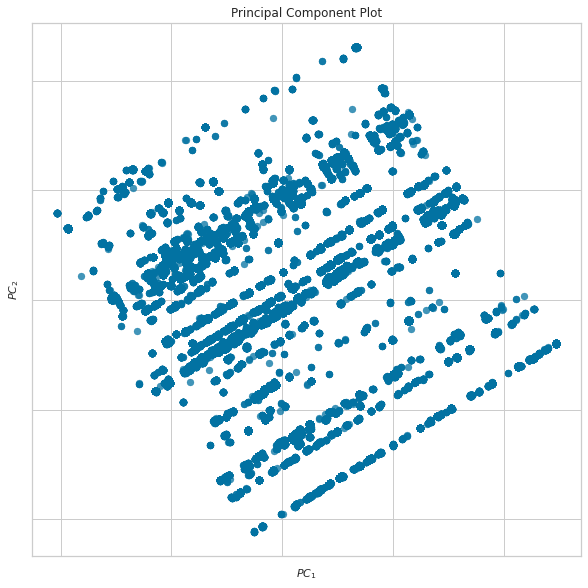

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [122]:
visualizer = ybPCA(scale=True, projection=2,
                   #proj_features=True,
                   #heatmap=True
                   size=(600,600)
                  )
visualizer.fit_transform(X_train)
visualizer.show()

In [87]:
# PyOD
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [75]:
'''
clf=IForest(n_estimators=100, max_samples='auto', contamination=0.01,
            max_features=1.0, bootstrap=False, n_jobs=-1, behaviour='old', 
            random_state=42, verbose=0)
'''

In [88]:
clf = PCA(standardization=True, n_components=2, contamination=0.01, random_state=42, whiten=False)

In [89]:
clf.fit(X_train)

PCA(contamination=0.01, copy=True, iterated_power='auto', n_components=2,
  n_selected_components=None, random_state=42, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

2 components are sufficient in our case to explain more than 80% of the variance in the training dataset.

In [93]:
clf.explained_variance_ratio_

array([0.47661401, 0.35998868])

## 6. Compute Anomaly Scores

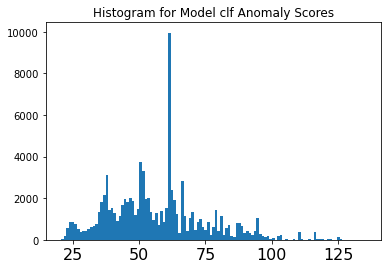

In [90]:
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model clf Anomaly Scores")
plt.show()

The scores appear to be almost normally distributed, with a few outliers. Those are our candidate anomalous points, possibly indicative of fraud.

### 6b. Visualization

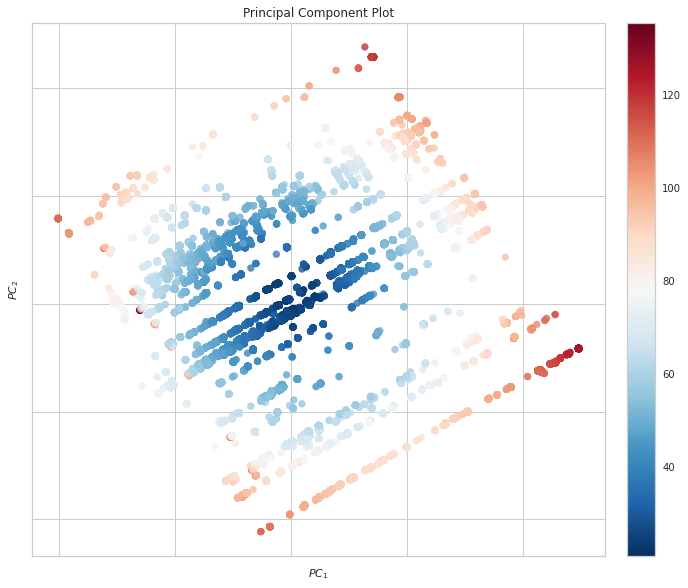

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [137]:
visualizer = ybPCA(scale=True, projection=2,
                   colormap='RdBu_r',
                   size=(700,600),
                   title= "Claim Anomaly Score by PCA projected in 2D",
                  )
visualizer.fit_transform(X_test, y_test_scores, )
visualizer.show()

The threshold below corresponds to the contamination factor, in this case top 1% of scores

In [125]:
clf.threshold_

110.73337340524081

Using the threshold, we can compute the outlier probability

In [126]:
outlier_prob, outlier_conf=clf.predict_proba(X_test, return_confidence=True)

In [134]:
test_result=X_test
test_result['Outlier_Prob']=outlier_prob[:,1]
test_result['Confidence']=outlier_conf
test_result

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72,Outlier_Prob,Confidence
335309,1,5,4,9488,3,0.120675,0.201952,0.016631,-0.097508,-0.007115,0.016968,-0.075978,0.068888,0.125742,0.002709,0.071635,-0.091664,-0.049314,0.005722,0.015234,-0.054300,-0.082746,0.157439,-0.012441,-0.106035,0.076108,-0.080540,-0.134149,-0.010937,-0.016505,0.061978,-0.014361,0.119844,0.056626,-0.020084,-0.029962,0.022330,0.041179,-0.025759,-0.029406,-0.074955,-0.030426,-0.011473,0.054333,-0.026959,0.015414,0.047803,0.179449,-0.102355,0.077302,-0.028460,0.050874,-0.019911,0.042651,-0.100551,0.124922,0.037135,0.128747,0.074973,-0.015032,-0.078275,0.039118,0.033980,0.054956,-0.078365,0.029308,-0.175296,0.051134,0.022805,-0.030223,0.054248,-0.037676,0.025947,-0.007045,-0.140553,0.052676,-0.072297,-0.037381,0.061021,0.059076,-0.091532,0.058264,0.061308,0.001065,-0.142989,-0.031506,-0.039569,-0.064816,0.058493,0.052753,0.070026,-0.014392,0.137945,-0.029073,0.036024,-0.006240,0.021021,0.160113,-0.014758,0.059556,0.046897,-0.066473,-0.011780,0.011229,0.017582,0.128911,0.022148,-0.058304,0.014589,-0.096898,-0.027262,-0.029671,0.123899,0.040843,0.045195,-0.069870,0.012284,0.027827,-0.003213,0.005371,-0.026589,-0.131927,-0.038041,0.073685,-0.011749,-0.079195,-0.091832,0.044990,-0.049877,0.002762,0.089479,0.021317,-0.042235,0.127261,0.120207,0.056663,0.015309,0.003260,-0.010602,-0.036816,0.123119,0.065537,0.048319,0.009753,0.021081,0.013661,-0.067624,-0.003660,0.027462,0.375208,1.0
13750,2,4,2,5883,1,0.058137,0.098304,0.010049,-0.050566,-0.007533,0.014420,-0.030716,0.035472,0.057542,-0.000768,0.037039,-0.040829,-0.024185,0.002240,0.007395,-0.025815,-0.045660,0.077978,-0.014151,-0.051476,0.037467,-0.041656,-0.061675,-0.008325,-0.003455,0.031836,-0.007652,0.055585,0.023335,-0.009007,-0.010264,0.010907,0.020017,-0.011084,-0.007498,-0.034620,-0.016358,-0.000837,0.023217,-0.011273,0.007849,0.025536,0.085185,-0.048123,0.041153,-0.017644,0.023180,-0.008670,0.021355,-0.048298,0.056612,0.016152,0.058799,0.036355,-0.004269,-0.034382,0.017191,0.015237,0.022401,-0.039443,0.012412,-0.080830,0.026188,0.008525,-0.017304,0.027166,-0.021187,0.012976,-0.004051,-0.061163,0.020803,-0.032856,-0.016798,0.019271,0.025608,-0.041866,0.022489,0.025147,0.000364,-0.062264,-0.015860,-0.017602,-0.025556,0.027300,0.022966,0.027984,-0.003173,0.055433,-0.013895,0.017731,-0.001681,0.008186,0.064538,-0.005985,0.024826,0.017216,-0.025714,-0.001657,0.003749,0.010293,0.050211,0.007963,-0.024355,0.011482,-0.043723,-0.011689,-0.009531,0.049983,0.022233,0.018028,-0.033901,0.006776,0.012072,-0.003493,0.002917,-0.011124,-0.056201,-0.013051,0.029624,-0.006405,-0.028624,-0.040229,0.019572,-0.022288,-0.001602,0.039290,0.006862,-0.015052,0.048678,0.050168,0.020664,0.009420,-0.000268,-0.002590,-0.016424,0.05

In [140]:
test_result.columns

Index(['Beneficiary gender code', 'Beneficiary Age category code',
       'Inpatient days code', 'DRG quintile average payment amount',
       'DRG quintile payment amount code', 'DRG_F1', 'DRG_F2', 'DRG_F3',
       'DRG_F4', 'DRG_F5',
       ...
       'PRC_F65', 'PRC_F66', 'PRC_F67', 'PRC_F68', 'PRC_F69', 'PRC_F70',
       'PRC_F71', 'PRC_F72', 'Outlier_Prob', 'Confidence'],
      dtype='object', length=151)

In [158]:
test_result.groupby('DRG quintile average payment amount')['Outlier_Prob'].median()

DRG quintile average payment amount
0         0.405770
799       0.319680
898       0.647441
1019      0.299179
1030      0.312329
            ...   
166845    0.495100
174385    0.604333
211840    0.691143
222276    0.699951
329467    1.000000
Name: Outlier_Prob, Length: 1260, dtype: float64